<a href="https://colab.research.google.com/github/andresf9824/TFM/blob/main/UnetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

# Commented out IPython magic to ensure Python compatibility.
# %matplotlib inline
import numpy as np
import torch
torch.cuda.set_device(0)

"""Function por stablishing the seed for reproducibility"""

number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [24]:
random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [25]:
import os

nombre_del_archivo = 'Umbralizadas.rar'
os.system(f'unrar x {nombre_del_archivo}')


65280

In [26]:
path = Path("Umbralizadas/")
path_images = path/"Images"
path_labels = path/"Labels"

In [27]:
test_name = "test"

In [28]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels").replace(".jpg",".png"))


In [29]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [30]:
codes

array(['Background', 'Bacteria'], dtype='<U10')

In [31]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

In [32]:
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['Bacteria']

{'Background': 0, 'Bacteria': 1}


In [33]:
def tumour(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [34]:
monitor_training="valid_loss"
comp_training=np.less

In [35]:
monitor_evaluating="dice"
comp_evaluating=np.greater

patience=3


In [13]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    Flip,
    VerticalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug):
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transformPipeline=Compose([
                        Flip(p=0.5),
                        VerticalFlip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self):
        pass
    def encodes(self, x):
        img,mask = x

        #Convert to array
        mask = np.array(mask)

        # Change 255 for 1
        mask[mask==255]=1

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask


In [14]:
def segmentron_splitter(model):
    return [params(model.backbone), params(model.head)]


In [15]:
manual_name="train"

path_manual_img = path_images
path_manual_lbl = path_labels

fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

size = 1002
bs = 1


In [36]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)



Setting-up type transforms pipelines
Found 757 items
2 datasets of sizes 444,313
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y_fn -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      Umbralizadas/Images/train/G99c-0.3.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=1027x1014
  Pipeline: get_y_fn -> PILBase.create
    starting from
      Umbralizadas/Images/train/G99c-0.3.jpg
    applying get_y_fn gives
      Umbralizadas/Labels/train/G99c-0.3.png
    applying PILBase.create gives
      PILMask mode=L size=1027x1014

Final sample: (PILImage mode=RGB size=1027x1014, PILMask mode=L size=1027x1014)


Found 757 items
2 datasets of sizes 444,313
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y_fn -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>,

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.241954,0.342720,0.999589,0.005710,0.002863,04:13
1,0.425010,0.311292,0.967776,0.611308,0.440205,04:08


Better model found at epoch 0 with valid_loss value: 0.34272024035453796.
Better model found at epoch 1 with valid_loss value: 0.31129154562950134.


epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.253311,0.315837,0.963533,0.628081,0.457812,04:08
1,0.230261,0.324917,0.966909,0.616870,0.445995,04:07
2,0.310921,0.297604,0.967448,0.613431,0.442409,04:08
3,0.236697,0.333188,0.969192,0.619359,0.448602,04:09
4,0.323011,0.352641,0.966768,0.614326,0.443341,04:08


Better model found at epoch 0 with valid_loss value: 0.31583747267723083.
Better model found at epoch 2 with valid_loss value: 0.29760393500328064.


epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.253311,0.315837,0.963533,0.628081,0.457812,04:08
1,0.230261,0.324917,0.966909,0.616870,0.445995,04:07
2,0.310921,0.297604,0.967448,0.613431,0.442409,04:08
3,0.236697,0.333188,0.969192,0.619359,0.448602,04:09
4,0.323011,0.352641,0.966768,0.614326,0.443341,04:08
5,0.294719,0.338210,0.967681,0.614360,0.443377,04:08


No improvement since epoch 2: early stopping


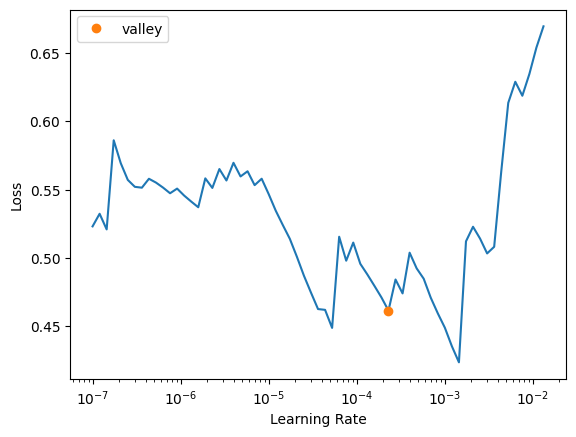

In [37]:

fname="unetModel"

callbacksFitBeforeUnfreeze = [
    # ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)
]

learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34",
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-3,
                                 pretrained=True, normalize=True,cbs=callbacksFitBeforeUnfreeze).to_fp16()
learn.lr_find() # find learning rate
#learn.recorder
learn.freeze() # Freezing the backbone
learn.fine_tune(15,freeze_epochs=2)